In [1]:
# Script to calculate originality

# Generality: how diverse is the impact of a patent
# This is done by calculating the herfindal index of citing patents

In [2]:
# Jan 22th, 2020
# Copy and paste from generality
# Join generality and generality_2
# mirror the script to reflect originality
# the only difference should be to change 'citation_id' by 'patent_id' in some fields
# total citations tend to be much smaller


# Jan 16th, 2020
# Due to performance problems in the HPC, this script was divided in two, the script following this is generality_2
# generality > 1 is not an error, but a consequence of adopting WIPO
# it seems that the original calculation had only one class per patent
# WIPO provides multiple classes - so when you divide by the total number of citations, 
#  you do not have the proportion of classes cited anymore
# to correct this issue, I can calculate Generality and Originality based only on the first WIPO class

# Jan 13th, 2020
# Script is running but there are two major issues
# - there should not exist generality > 1 , so there is an error in calculation
# - too many NANs (about 400k), but I will tackle this issue in 'too_many_nans.ipynb'

# to tackle the first problem, I'll begin by creating a subset of the database
# to do that, I'll use USPTO classification system

In [3]:
# Trying to save memory is leading to a small nightmare 
# I am postponing the use of dask modules

In [4]:
import sys
sys.path.append('/home/rkogeyam/scripts/')
from sampler import sampler

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import dask.dataframe as dd

import gzip

In [5]:
%matplotlib inline

In [6]:
# wipo_horiz.csv
# from wipo_horiz.ipynb
# Original WIPO classification reshaped
# patent_id:    patent number
# field_id_n :  'n' is the WIPO class

# uspatentcitation.tsv
# uuid:         unique id
# patent_id:    patent number
# citation_id:  identifying number of patent to which select patent cites
# date:         date select patent (patent_id) cites patent (citation_id)
# name:         name of cited record
# kind:         WIPO document kind codes 
#               (http://www.uspto.gov/learning-and-resources/support-centers/electronic-business-center/kind-codes-included-uspto-patent)	2002 and After
# country:      country cited patent was granted (always US)
# category:     who cited the patent (examiner, applicant, other etc) - 2002 and After
# sequence:     order in which this reference is cited by select patent	all


In [7]:
src= '/home/rkogeyam/PATENT_CITATION/data/originality_temp.csv.gz'
dst = '/home/rkogeyam/PATENT_CITATION/data/originality.csv.gz'

In [8]:
file_src=gzip.open(src, 'r')
df=pd.read_csv(file_src, usecols=['patent_id', 'wipo_sector_id'])

In [9]:
# df=df.drop(['patent_id'], axis=1)
# df.drop('Unnamed: 0', inplace=True, axis=1)
df = pd.get_dummies(df, columns=['wipo_sector_id'])

In [10]:
#from generality_2

# group on citation_id - thus adding all patents citing one receiver (citation_id)
# thus this is generality
# its the impact of a given patent

# the index is equivalent to 1 - herfindal
# this way, the closer to 1, the more general

# the denominator is total citations squared
# should be easy to check with citation values
total_citation=df.groupby('patent_id').count().iloc[:,0] #different from generality
total_citation=np.square(total_citation)

In [11]:
# the numerator is the sum of the squares of citations in each class
df=df.groupby('patent_id').sum().fillna(0) #in theory, I would not need fillna, check later
# df.drop(['Unnamed: 0', 'sequence', 'patent_id_raw', 'citation_id'], inplace=True, axis=1)
df=np.square(df) #element-wise squaring
df=df.sum(axis='columns') #sum all columns, per row

In [12]:
df=pd.concat([df, total_citation], axis=1)
df.columns=['df_squared', 'total_citation']
#herfindal 

df['herfindal']=df['df_squared']/df['total_citation'] #its a measure of concentration

df['originality']=1-df['herfindal'] # as defined in Hall et al, 2001

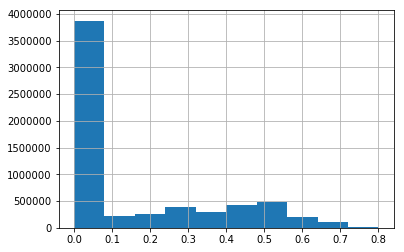

In [13]:
df['originality'].hist()

In [14]:
df.to_csv(dst, compression='gzip')